In [1]:
"""
task1: 短期实习1
autor: 邵宇辉202083300563 20级气象学(8)班
time: 2023/03/15
"""
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from datetime import datetime
import os
import matplotlib.colors as mcolors
from scipy.stats import pearsonr
from statsmodels.stats.weightstats import ztest
from metpy.interpolate import inverse_distance_to_grid
from scipy.interpolate import griddata
from pykrige.ok import OrdinaryKriging
from eofs.standard import Eof
from math import radians, cos, sin, asin, sqrt
from tqdm import tqdm
from matplotlib import cm
from metpy.units import units
from metpy.constants import earth_avg_radius
import metpy.calc as mpcalc
import matplotlib.patches as patches
from cartopy.util import add_cyclic_point
from metpy.constants import earth_avg_radius
import xarray as xr
import netCDF4 as nc

c:\Users\syh\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
data = xr.open_dataset(r'../Practice1/hgt.mon.mean.199101-202001.nc')
hgt_clm = data.z.loc[:,500].sum(dim='time')/30/9.8              #1991-2020年500hPa位势高度气候态
hgt_anom = data.z.loc['2008-01-01',500]/9.8 - hgt_clm           #2008年1月500hPa位势高度异常
hgt_latanom = data.z.loc['2008-01-01',500]/9.8 - data.z.loc[:,500].sum(dim='time').mean(dim='longitude')/30/9.8   #2008年1月500hPa位势高度纬偏值
lon = data.longitude.values
lat = data.latitude.values
# 补足缺失
hgt_anom, lon1 = add_cyclic_point(hgt_anom, coord= lon)
hgt_clm, lon1 = add_cyclic_point(hgt_clm, coord= lon)
hgt_latanom, lon1 = add_cyclic_point(hgt_latanom, coord= lon)
lon, lat = np.meshgrid(lon1, lat)

C:\Users\syh\AppData\Local\Temp/ipykernel_12900/4044994813.py:17: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.savefig(r'../PIC/P1_1991_2020_500hPa_hgtclim1.svg',format='svg', dpi=300, pad_inches= 0.1, bbox_inches= 'tight', rasterized=True)
C:\Users\syh\AppData\Local\Temp/ipykernel_12900/4044994813.py:17: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error in 3.6
  fig.savefig(r'../PIC/P1_1991_2020_500hPa_hgtclim1.svg',format='svg', dpi=300, pad_inches= 0.1, bbox_inches= 'tight', rasterized=True)


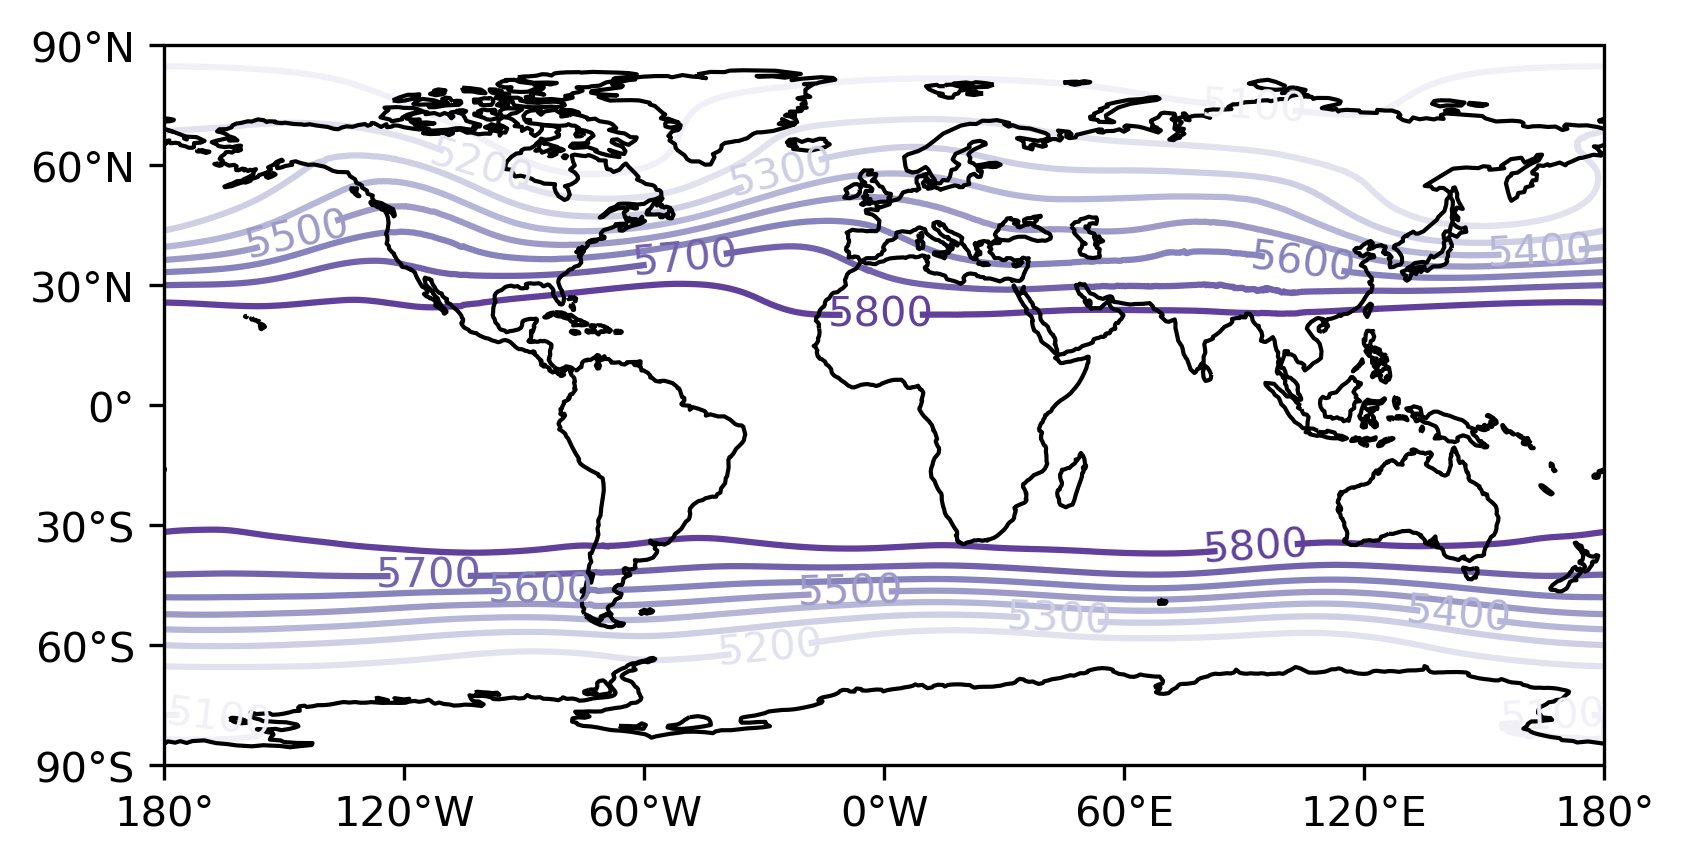

In [6]:
# 绘图-30年气候态
fig = plt.figure(figsize=(12,6), dpi= 300, facecolor='white',constrained_layout=True)
ax = fig.add_axes([0.1, 0.1, 0.6, 0.4], projection= ccrs.PlateCarree(central_longitude= 0))
ax.coastlines()
ax.set_xticks([-180,-120,-60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
ax.set_yticks([-90,-60,-30,0, 30, 60, 90], crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label= True))
ax.yaxis.set_major_formatter(LatitudeFormatter())
ax.set_extent([-180, 180, -90, 90], crs= ccrs.PlateCarree())
C = ax.contourf(lon, lat, hgt_clm, transform= ccrs.PlateCarree(),cmap='Purples', extend='both', zorder=1,levels= np.arange(5000,6100,100))
cbar_ax = fig.add_axes([0.2,0.02,0.4,0.03])
fig.colorbar(C,
        orientation= 'horizontal', cax= cbar_ax,
        ticks= np.linspace(5000, 6000,5+1)
        )
fig.savefig(r'../PIC/P1_1991_2020_500hPa_hgtclim.svg',format='svg', dpi=300, pad_inches= 0.1, bbox_inches= 'tight', rasterized=True)

In [ ]:
# 绘图-2008年1月异常
fig = plt.figure(figsize=(12,6), dpi= 300, facecolor='white',constrained_layout=True)
ax = fig.add_axes([0.1, 0.1, 0.6, 0.4], projection= ccrs.PlateCarree(central_longitude= 0))
ax.coastlines()
ax.set_xticks([-180,-120,-60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
ax.set_yticks([-90,-60,-30,0, 30, 60, 90], crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label= True))
ax.yaxis.set_major_formatter(LatitudeFormatter())
ax.set_extent([-180, 180, -90, 90], crs= ccrs.PlateCarree())
C = ax.contourf(lon, lat, hgt_anom, transform= ccrs.PlateCarree(),cmap='bwr', extend='both', zorder=1,levels= np.arange(-200,210,10))
cbar_ax = fig.add_axes([0.2,0.02,0.4,0.03])
fig.colorbar(C,
        orientation= 'horizontal', cax= cbar_ax,
        ticks= np.linspace(-200, 200,5+1)
        )
# fig.savefig(r'../PIC/P1_1991_2020_500hPa_hgtanom.svg',format='svg', dpi=300, pad_inches= 0.1, bbox_inches= 'tight', rasterized=True)

In [ ]:
# 绘图-2008年1月纬偏
fig = plt.figure(figsize=(12,6), dpi= 300, facecolor='white',constrained_layout=True)
ax = fig.add_axes([0.1, 0.1, 0.6, 0.4], projection= ccrs.PlateCarree(central_longitude= 0))
ax.coastlines()
ax.set_xticks([-180,-120,-60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
ax.set_yticks([-90,-60,-30,0, 30, 60, 90], crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label= True))
ax.yaxis.set_major_formatter(LatitudeFormatter())
ax.set_extent([-180, 180, -90, 90], crs= ccrs.PlateCarree())
C = ax.contourf(lon, lat, hgt_latanom, transform= ccrs.PlateCarree(),cmap='bwr', extend='both', zorder=1,levels= np.arange(-150,160,10))
cbar_ax = fig.add_axes([0.2,0.02,0.4,0.03])
fig.colorbar(C,
        orientation= 'horizontal', cax= cbar_ax,
        ticks= np.linspace(-150, 150,5+1)
        )
fig.savefig(r'../PIC/P1_1991_2020_500hPa_hgtlatanom.svg',format='svg', dpi=300, pad_inches= 0.1, bbox_inches= 'tight', rasterized=True)